In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional
from collections import defaultdict, deque
from Orderbook import Order, OrderBook

df = pd.read_csv('../LOBSTER_SampleFile_AMZN_2012-06-21_1/AMZN_2012-06-21_34200000_57600000_message_1.csv')
df['Price'] = np.vectorize(lambda x:x/10000)(df['Price'])

In [12]:
import math

def calc_reservation_price(mid, exposure, tick, vol, risk):
    end = 57600 # sec after midnight
    return mid - exposure * risk * vol * (end - tick)

def calc_spread(risk, vol, tick, impact):
    end = 57600
    return 0.5 * (risk * vol * (end-tick) + (2/risk) * math.log(1 + risk/impact))

In [75]:
book = OrderBook()

data = []
myQueue = deque()
ct = 0 

# prefix var calculations
# sum_x = 0.0
# sum_x_squared = 0.0
# sig_sq = 0
varWindow = 1000
vars = []

j = 0


prev = None # Tuple (time, last mid)

cash, exposure = 0, 0
cList = []
eList = []
times = []
total = []
last_a, last_b = None, None
k_a, k_b = None, None
k = None

# rolling density calc period
pi = 0.5
# bidUpdates = deque()
# askUpdates = deque()
updates = deque()

# trading params
totTime = (57600 - 32400)
dt = 0.005 # total trading time * dt param in paper
tradWindow = totTime * dt + 32400
risk = 0.1
vol = None # init
initId = 12345

latency = 0.0

for i in range(len(df)):

    row = df.iloc[i]

    # Inputting Orderbook Updates
    while myQueue and myQueue[0].datetime < row.Time: # give != pref to market
        curr = myQueue.popleft()
        book.placeOrder(curr)

    if row.Type == 1:
        curr = Order(row.OrderId, row.Time, ('BID' if row.Direction == 1 else 'ASK'), row.Price, row.Size, 'resting')
        book.placeOrder(curr)
    elif row.Type == 2:
        book.partialCancel(row.OrderId, row.Size)
    elif row.Type == 3:
        book.cancelOrder(row.OrderId)
    elif row.Type == 4:
        # Execution of visible
        book.executeOrder(row.OrderId, 'market')
    elif row.Type == 5:
        # Execution of hidden
        continue
    elif row.Type == 7:
        # Halts
        continue
    
    # Orderbook Reconstruction
    bestAsk = book.bestAsk.getMin()
    bestBid = book.bestBid.getMin()

    bookListing = [row.Time]

    if bestAsk and bestBid:
        bookListing.append(bestAsk.price)
        bookListing.append(book.volumeMap[bestAsk.price]['ASK'])

        bookListing.append(bestBid.price)
        bookListing.append(book.volumeMap[bestBid.price]['BID'])

        data.append(bookListing)

        # "Trading"

        currMid = (bestAsk.price + bestBid.price)/2

        if 'me' in book.clientMap: 
            exposure = book.clientMap['me']['Exposure']
            eList.append(exposure)
            cash = book.clientMap['me']['Cash']
            cList.append(cash)
            times.append(row.Time)
            total.append(cash + exposure * currMid)

        curr = (row.Time, currMid)

        # Calc liquidity
        updates.append(curr)
        while updates and updates[0][0] <= (curr[0] - pi):
            updates.popleft()
        if updates:
            if not last_b: last_b = len(updates) / pi
            else:
                temp = len(updates) / pi
                if temp != last_b:
                    k = (temp * last_b) / abs(temp - last_b)
                last_b = temp

        # while bidUpdates and bidUpdates[0][0] <= (curr[0] - pi):
        #     bidUpdates.popleft()
        # if row.Direction == 1: bidUpdates.append(curr)
        # if not last_b: last_b = len(bidUpdates) / pi
        # else: 
        #     temp = len(bidUpdates) / (bidUpdates[-1][0] - bidUpdates[0][0])
        #     if temp != last_b:
        #         k_b = (temp * last_b) / (temp - last_b)
        #     last_b = temp

        # while askUpdates and askUpdates[0][0] <= (curr[0] - pi):
        #     askUpdates.popleft()
        # if row.Direction != 1: askUpdates.append(curr)
        # if not last_a: last_a = len(askUpdates) / pi
        # else: 
        #     temp = len(askUpdates) / (askUpdates[-1][0] - askUpdates[0][0])
        #     if temp != last_b:
        #         k_a = (temp * last_b) / (temp - last_b)
        #     last_a = temp

        # Calc prefix variance    
        # if prev:
        x = currMid
        if j < varWindow: vars.append(x)
        else: vars[j % varWindow] = x
        vol = np.var(vars)
        j += 1
            # print(f"currmid: {currMid}")
            # sum_x += x
            # sum_x_squared += x * x

            # if j == 0:
                # vol = 0 
            # else:
                # mean = sum_x / (j + 1)
                # variance = (sum_x_squared - (sum_x * sum_x) / (j + 1)) / j
                # vol = variance


        # See if trading window has opened
        if vol and k and row.Time > tradWindow:
            # doTrade
            res = calc_reservation_price(currMid, exposure, row.Time, vol, risk)
            bidSpread = calc_spread(risk, vol, row.Time, k)
            askSpread = calc_spread(risk, vol, row.Time, k)
            print(k)
            if bidSpread < 10:
            # def calc_spread(risk, vol, tick, impact):
                myQueue.append(Order(initId, row.Time + latency, 'BID', res - bidSpread, 50, 'me'))
                myQueue.append(Order(initId + 1, row.Time + latency, 'ASK', res + askSpread, 50, 'me'))
 
            initId += 2

            tradWindow += dt * totTime

        prev = curr

        

    

12.0
24.0
40.0
60.0
24.0
2.6666666666666665
4.0
4.0
4.0
12.0
12.0
24.0
40.0
60.0
4.0
4.0
4.0
4.0
4.0
2.6666666666666665
2.142857142857143
2.5
2.6666666666666665
2.4
2.4
2.5
3.0
3.0
24.0
40.0
12.0
3.0
2.2222222222222223
2.3333333333333335
2.6666666666666665
2.3333333333333335
3.0
2.0606060606060606
4.0
4.0
2.2857142857142856
12.0
3.0
4.0
2.6666666666666665
3.0
3.0
24.0
4.0
4.0
4.0
2.111111111111111
2.6666666666666665
4.0
12.0
2.3333333333333335
4.0
2.5
9.6
4.0
3.0
4.0
2.125
3.0
4.0
2.6666666666666665
3.0
2.6666666666666665
4.0
2.0317460317460316
4.0
2.2857142857142856
4.0
2.2222222222222223
4.0
2.2222222222222223
3.0
4.0
4.0
2.1818181818181817
4.0
2.2857142857142856
2.111111111111111
2.066666666666667
2.5
3.0
4.0
4.0
4.0
4.0
3.0
3.0
2.5
2.6666666666666665
4.0
2.111111111111111
3.0
2.25
2.6666666666666665
2.5
4.0
2.1666666666666665
4.0
2.4
2.5
2.1176470588235294
2.4
3.0
4.0
2.25
2.4
4.0
2.2222222222222223
4.0
2.5
4.0
4.0
2.4
4.0
2.5
4.0
2.2222222222222223
2.1052631578947367
4.0
2.5
2.25


390.34160789458656


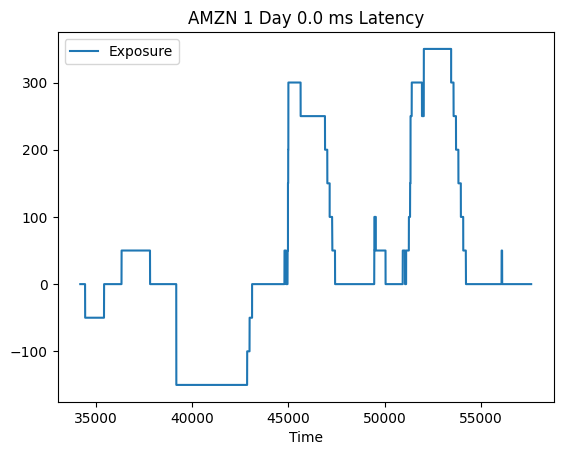

In [80]:
stats = pd.DataFrame(data=zip(times, cList, eList, total), columns=['Time','Cash', 'Exposure', 'Returns'])
stats.plot(x='Time', y="Exposure", kind="line")
plt.title(f'AMZN 1 Day {latency * 1000} ms Latency')
print(list(stats.Returns)[-1])

In [ ]:
import numpy as np
print(ct)
newdf = pd.DataFrame(data=data, columns=['Tick','Ask', 'AV', 'Bid', 'BVol'])
newdf['Mid'] = np.vectorize(lambda a,b: (a+b)/2)(newdf['Ask'], newdf['Bid'])
# newdf.head(10)
print(newdf)

0
              Tick     Ask     AV     Bid   BVol      Mid
0      34200.87379  223.95   75.0  223.84  100.0  223.895
1      34200.88178  223.95   75.0  223.84  100.0  223.895
2      34200.89150  224.00  100.0  223.84  100.0  223.920
3      34201.29095  223.86  100.0  223.84  100.0  223.850
4      34201.29141  224.00  100.0  223.84  100.0  223.920
...            ...     ...    ...     ...    ...      ...
54763  57599.54583  220.63  100.0  220.58  147.0  220.605
54764  57599.54583  220.63  100.0  220.58  147.0  220.605
54765  57599.90399  220.63  100.0  220.58  147.0  220.605
54766  57599.95824  220.63  200.0  220.58  147.0  220.605
54767  57599.95936  220.63  100.0  220.58  147.0  220.605

[54768 rows x 6 columns]


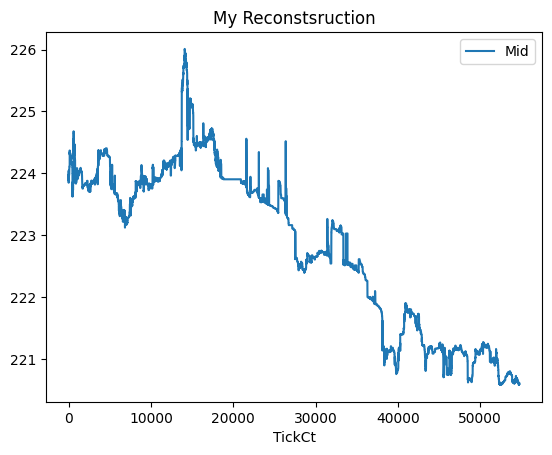

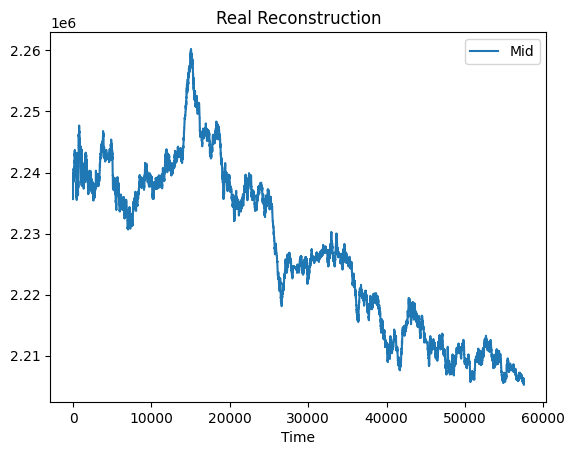

In [ ]:
newdf.to_csv('add_cancel.csv')
# newdf['Mid'] = np.vectorize(lambda a: a/10000)(newdf['Mid']) 
newdf['TickCt'] = newdf.index
newdf.plot(x='TickCt', y='Mid', kind='line')
plt.title('My Reconstsruction')
plt.show()

real_df = pd.read_csv('../LOBSTER_SampleFile_AMZN_2012-06-21_1/AMZN_2012-06-21_34200000_57600000_orderbook_1.csv')
real_df['Time'] = real_df.index
real_df['Mid'] = np.vectorize(lambda a,b: (a+b)/2)(real_df['BestAsk'], real_df['BestBid'])
# real_df['Mid'] = np.vectorize(lambda a: a/10000)(real_df['Mid'])
real_df.plot(x='Time', y='Mid')
plt.title('Real Reconstruction')
plt.show()

In [ ]:
print(book.clientMap)
print(bestAsk.price)

defaultdict(<class 'dict'>, {'resting': {'Cash': -22216399.700000025, 'Exposure': 100159.0}, 'market': {'Cash': 22216399.700000025, 'Exposure': -100159.0}})
220.63
